In [1]:
import pandas as pd
import numpy as np
import scipy
from sklearn.preprocessing import MinMaxScaler
from copy import deepcopy
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import pprint
from scipy.stats import pearsonr, spearmanr
from scipy import stats
from scipy.interpolate import CubicSpline
import warnings
warnings.filterwarnings("ignore")
import arviz as az
import scipy
import matplotlib.patches as patches
import statsmodels.stats.api as sms
from sklearn.metrics import r2_score
import scipy.stats.kde as kde

# Read meta data

In [7]:
df_meta = pd.read_csv('metadata.tsv', sep='\t', index_col=0)
df_meta = df_meta.drop('#q2:types')
df_meta.Subject = [s.strip() for s in df_meta.Subject]
df_meta = df_meta[['Treatment','Subject','Dose','week']]
df_meta = df_meta[df_meta.Treatment=='Maize']
df_meta.week = df_meta.week.astype(int)
df_meta = df_meta.rename({'week':'Day'}, axis=1)
df_meta = df_meta.drop(['Treatment','Dose'], axis=1)
df_meta.head()

,Subject,Day
sample-id,,
SRR10022237,F08,0
SRR10022130,F08,1
SRR10022131,F08,2
SRR10022132,F08,3
SRR10022159,F08,4


# Read SCFA

In [23]:
df_scfa = pd.read_csv('metadata.tsv', sep='\t', index_col=0)
df_scfa = df_scfa.drop('#q2:types')
df_scfa.Subject = [s.strip() for s in df_scfa.Subject]
df_scfa = df_scfa[['acetate','butyrate','propionate']]
df_scfa.columns = ['Acetate','Butyrate','Propionate']
df_scfa = df_scfa.loc[df_meta.index].astype('float64')
df_scfa.head()

,Acetate,Butyrate,Propionate
sample-id,,,
SRR10022237,24.492,7.584,8.336
SRR10022130,14.684,1.912,2.324
SRR10022131,23.440,7.508,9.064
SRR10022132,31.608,7.912,15.024
SRR10022159,24.984,8.224,11.164


In [24]:
df_scfa.corr()

,Acetate,Butyrate,Propionate
Acetate,1.000000,0.527127,0.637766
Butyrate,0.527127,1.000000,0.357930
Propionate,0.637766,0.357930,1.000000


# Read 16S data (relative abundance)

In [25]:
df_16S = pd.read_excel('16S_relative_abundance.xlsx', index_col=0)
df_16S = df_16S.loc[df_meta.index]
df_16S.head()

,Abiotrophia-defectiva,Absiella-argi,Acholeplasmatales-bacterium-canine-oral-taxon-316,Acidaminococcus,Acidaminococcus-sp.-Marseille-P2764,Acidaminococcus-sp.-Marseille-P2828,Acinetobacter,Actinobacillus,Actinobacteria,Actinobacteriota,...,bacterium-mpn-isolate-group-16,bacterium-oral-clone-ASCD05,butyrate-producing-bacterium-SM4/1,gut-metagenome,human-gut-metagenome,metagenome,mouse-gut-metagenome,rumen-bacterium-NK4A78,swine-fecal-bacterium-SD-Xyl5,wallaby-gut-metagenome
sample-id,,,,,,,,,,,,,,,,,,,,,
SRR10022237,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.025861,0.002732,0.014283,0.0,0.0,0.0,0.0
SRR10022130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.016473,0.006433,0.016353,0.0,0.0,0.0,0.0
SRR10022131,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.001284,0.022633,0.015146,0.0,0.0,0.0,0.0
SRR10022132,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.007602,0.017018,0.027184,0.0,0.0,0.0,0.0
SRR10022159,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.009133,0.014352,0.0,0.0,0.0,0.0


# Select the 40 most abundant taxa

In [26]:
topX = 40
df_16S_T = df_16S.T
df_16S_T['mean'] = df_16S_T.mean(axis=1)
df_16S_T = df_16S_T.sort_values(by=['mean'],axis=0,ascending=False)
df_16S_T = df_16S_T.drop('mean', axis=1)
df_16S_topX = df_16S_T.iloc[0:topX].T
df_16S_topX.head()

,Bacteroides,Agathobacter,Faecalibacterium,Bifidobacterium,Blautia,Faecalibacterium-sp.,gut-metagenome,Bifidobacterium-faecale,Prevotella,CAG-352,...,Bacteroides-plebeius,Coprococcus,Roseburia-faecis-M72/1,swine-fecal-bacterium-SD-Xyl5,Parabacteroides,[Eubacterium]-coprostanoligenes-group,Subdoligranulum,Parasutterella-excrementihominis,Erysipelotrichaceae-UCG-003,Christensenellaceae-R-7-group
sample-id,,,,,,,,,,,,,,,,,,,,,
SRR10022237,0.186355,0.001082,0.055834,0.011253,0.028972,0.017096,0.025861,0.0,0.0,0.0,...,0.0,0.004139,0.013580,0.0,0.040225,0.000000,0.000000,0.039982,0.002002,0.002570
SRR10022130,0.116392,0.007966,0.043827,0.006072,0.021102,0.027204,0.016473,0.0,0.0,0.0,...,0.0,0.012445,0.094568,0.0,0.026663,0.006162,0.001142,0.016803,0.002074,0.002014
SRR10022131,0.283062,0.000000,0.010482,0.003808,0.012450,0.021093,0.001284,0.0,0.0,0.0,...,0.0,0.000000,0.089334,0.0,0.015488,0.005262,0.000000,0.027810,0.000000,0.000000
SRR10022132,0.282698,0.000000,0.009103,0.025714,0.018238,0.002659,0.007602,0.0,0.0,0.0,...,0.0,0.000000,0.060093,0.0,0.017205,0.005318,0.000000,0.029781,0.000000,0.000000
SRR10022159,0.328617,0.001620,0.054957,0.011990,0.009066,0.095089,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.021056,0.0,0.029087,0.000000,0.000000,0.022113,0.000000,0.000000


In [27]:
# sample with minimum absolute abundance coverage
(df_16S_topX.sum(axis=1)/df_16S.sum(axis=1)).min()

0.6596482736366569

# Calculate derivative

In [28]:
df_scfa_meta = pd.merge(df_meta, df_scfa, left_index=True, right_index=True, how='inner')
df_scfa_deriv = deepcopy(df_scfa_meta)
for curr_mice in set(df_scfa_deriv.Subject):
    curr_df = df_scfa_meta[df_scfa_meta.Subject==curr_mice]
    for scfa in ['Acetate','Butyrate','Propionate']:
        xdata = np.array(curr_df['Day'])
        ydata = np.array(curr_df[scfa])
        cs = CubicSpline(xdata, ydata)
        csd1 = cs.derivative(nu=1)
        ydata_d1 = csd1(xdata)
        df_scfa_deriv.loc[df_scfa_deriv.Subject==curr_mice, scfa] = ydata_d1
    
df_scfa_deriv = df_scfa_deriv[['Acetate','Butyrate','Propionate']]
df_scfa_deriv.head()

,Acetate,Butyrate,Propionate
sample-id,,,
SRR10022237,-25.886333,-18.589333,-17.2730
SRR10022130,2.872167,3.603667,2.8065
SRR10022131,11.241667,3.946667,8.2310
SRR10022132,2.933167,-1.390333,2.3695
SRR10022159,-18.342333,3.762667,-11.4090


# Normalize max value of 16S data to 1

In [29]:
# normalize bacteria data using 
bacterial_taxa = list(df_16S_topX.columns)
df_16S_topX = df_16S_topX/df_16S_topX.max().max()
df_16S_topX.head()

,Bacteroides,Agathobacter,Faecalibacterium,Bifidobacterium,Blautia,Faecalibacterium-sp.,gut-metagenome,Bifidobacterium-faecale,Prevotella,CAG-352,...,Bacteroides-plebeius,Coprococcus,Roseburia-faecis-M72/1,swine-fecal-bacterium-SD-Xyl5,Parabacteroides,[Eubacterium]-coprostanoligenes-group,Subdoligranulum,Parasutterella-excrementihominis,Erysipelotrichaceae-UCG-003,Christensenellaceae-R-7-group
sample-id,,,,,,,,,,,,,,,,,,,,,
SRR10022237,0.567090,0.003293,0.169905,0.034244,0.088163,0.052025,0.078696,0.0,0.0,0.0,...,0.0,0.012595,0.041324,0.0,0.122407,0.000000,0.000000,0.121666,0.006092,0.007820
SRR10022130,0.354187,0.024241,0.133369,0.018478,0.064215,0.082784,0.050128,0.0,0.0,0.0,...,0.0,0.037870,0.287777,0.0,0.081137,0.018752,0.003476,0.051134,0.006312,0.006129
SRR10022131,0.861373,0.000000,0.031898,0.011587,0.037887,0.064186,0.003906,0.0,0.0,0.0,...,0.0,0.000000,0.271848,0.0,0.047131,0.016014,0.000000,0.084627,0.000000,0.000000
SRR10022132,0.860266,0.000000,0.027701,0.078249,0.055498,0.008091,0.023132,0.0,0.0,0.0,...,0.0,0.000000,0.182867,0.0,0.052357,0.016183,0.000000,0.090624,0.000000,0.000000
SRR10022159,1.000000,0.004929,0.167237,0.036487,0.027588,0.289362,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.064074,0.0,0.088513,0.000000,0.000000,0.067292,0.000000,0.000000


# Simple Correlation

In [30]:
lines = []
for scfa in ['Acetate','Butyrate','Propionate']:
    for t in bacterial_taxa:
        lines.append([scfa,
                     t,
                     pearsonr(df_scfa_deriv[scfa],df_16S_topX[t])[0],
                     spearmanr(df_scfa_deriv[scfa],df_16S_topX[t])[0]]
                    )
df_corr = pd.DataFrame(lines, columns=['SCFA','Variable','Pearson','Spearman'])
df_corr.head()

,SCFA,Variable,Pearson,Spearman
0,Acetate,Bacteroides,-0.064759,-0.086098
1,Acetate,Agathobacter,-0.003963,0.064059
2,Acetate,Faecalibacterium,-0.079502,-0.017143
3,Acetate,Bifidobacterium,0.020018,0.097536
4,Acetate,Blautia,0.221573,0.141705


In [31]:
df_corr.to_excel('correlation_top40.xlsx')

# Elastic net

In [35]:
rows = []
for scfa in ['Acetate','Butyrate','Propionate']:
    dydt = np.asarray(list(df_scfa_deriv[scfa]))
    X = np.asarray(df_16S_topX.values)
    l1_ratio = [1e-4, .1, .3, .5, .7, .9, .95, .99, 1]
    reg = ElasticNetCV(
        eps=1e-4,
        n_alphas=10000,
        cv=5,
        random_state=0,
        max_iter=100000,
        tol=1e-6,
        l1_ratio=l1_ratio
    ).fit(X, dydt)
    clf = ElasticNet(l1_ratio=reg.l1_ratio_, 
                     alpha=reg.alpha_, 
                     random_state=0,
                     max_iter=100000,
                     tol=1e-6,
                    ).fit(X,dydt)
    rows.append([scfa, reg.alpha_, reg.l1_ratio_, clf.score(X,dydt)]+ list(clf.coef_))
df_elasticnet = pd.DataFrame(rows, columns=['SCFA','BestAlpha','L1Ratio','R2']+list(df_16S_topX.columns)).set_index('SCFA')
#df_elasticnet = df_elasticnet.loc[:, (df_elasticnet != 0).any(axis=0)]
df_elasticnet.head()

,BestAlpha,L1Ratio,R2,Bacteroides,Agathobacter,Faecalibacterium,Bifidobacterium,Blautia,Faecalibacterium-sp.,gut-metagenome,...,Bacteroides-plebeius,Coprococcus,Roseburia-faecis-M72/1,swine-fecal-bacterium-SD-Xyl5,Parabacteroides,[Eubacterium]-coprostanoligenes-group,Subdoligranulum,Parasutterella-excrementihominis,Erysipelotrichaceae-UCG-003,Christensenellaceae-R-7-group
SCFA,,,,,,,,,,,,,,,,,,,,,
Acetate,0.010541,0.1000,0.158873,-9.021636,2.756776,-7.031098,0.236019,16.847553,-3.101245,-10.52501,...,15.024566,7.462447,15.820383,8.090715,-0.977816,-6.542534,2.204287,4.07743,-5.576022,-0.767852
Butyrate,1284.172383,0.0001,0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.00000,...,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.00000,0.000000,0.000000
Propionate,0.159845,0.5000,0.016256,-0.889530,0.551030,-0.000000,-0.000000,0.000000,0.000000,-0.00000,...,0.000000,0.000000,0.180067,0.000000,-0.000000,0.000000,0.000000,-0.00000,-0.000000,0.000000


In [36]:
df_elasticnet = df_elasticnet.stack().reset_index()
df_elasticnet = df_elasticnet[~df_elasticnet.level_1.isin(['BestAlpha','L1Ratio','R2'])]
df_elasticnet.columns=['SCFA','Variable','Coefficient']
df_elasticnet = df_elasticnet.reset_index(drop=True)
df_elasticnet.to_excel('elasticnet_summary_top40.xlsx')

# Random forest regression

## parameter optimization

In [37]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 30, num = 3)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

lines = []
for scfa in ['Acetate','Butyrate','Propionate']:
    dydt = np.asarray(list(df_scfa_deriv[scfa]))
    X = np.asarray(df_16S_topX.values)

    # grid search
    rf = RandomForestRegressor()
    rf_random = GridSearchCV(
        estimator = rf, 
        param_grid = random_grid, 
        cv = 5, 
        verbose=2, 
        n_jobs = -1)

    # fit the random search model
    rf_random.fit(X, dydt)
    
    # write to table
    lines.append([scfa,
           rf_random.best_params_['n_estimators'],
           rf_random.best_params_['max_features'],
           rf_random.best_params_['max_depth'],
           rf_random.best_params_['min_samples_split'],
           rf_random.best_params_['min_samples_leaf'],
           rf_random.best_params_['bootstrap']
           ])

df_opt_paras = pd.DataFrame(lines, columns=['SCFA','n_estimators','max_features','max_depth','min_samples_split','min_samples_leaf','bootstrap'])
df_opt_paras.head()

Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   59.7s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed: 17.8min
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed: 20.9min finished


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed: 17.8min
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed: 22.8min finished


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed: 18.0min
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed: 23.4min
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed: 28.2min finished


,SCFA,n_estimators,max_features,max_depth,min_samples_split,min_samples_leaf,bootstrap
0,Acetate,200,sqrt,10,2,1,False
1,Butyrate,200,sqrt,30,2,1,True
2,Propionate,200,sqrt,30,2,4,True


In [38]:
df_opt_paras.to_excel('optimal_rf_hyperparameters_top40.xlsx')

## run RF using best parameters

In [39]:
rows = []
for scfa in ['Acetate','Butyrate','Propionate']:
    dydt = np.asarray(list(df_scfa_deriv[scfa]))
    X = np.asarray(df_16S_topX.values)
    regr = RandomForestRegressor(
        random_state=0,
        bootstrap=list(df_opt_paras.loc[df_opt_paras.SCFA==scfa,'bootstrap'])[0],
        max_depth=None if str(list(df_opt_paras.loc[df_opt_paras.SCFA==scfa,'max_depth'])[0])=='nan' else list(df_opt_paras.loc[df_opt_paras.SCFA==scfa,'max_depth'])[0],
        max_features=list(df_opt_paras.loc[df_opt_paras.SCFA==scfa,'max_features'])[0],
        min_samples_leaf=list(df_opt_paras.loc[df_opt_paras.SCFA==scfa,'min_samples_leaf'])[0],
        min_samples_split=list(df_opt_paras.loc[df_opt_paras.SCFA==scfa,'min_samples_split'])[0],
        n_estimators=list(df_opt_paras.loc[df_opt_paras.SCFA==scfa,'n_estimators'])[0],
        n_jobs=-1
    )
    clf = regr.fit(X, dydt)
    rows.append([scfa, clf.score(X, dydt)]+ list(clf.feature_importances_))
df_rf = pd.DataFrame(rows, columns=['SCFA','R2']+list(df_16S_topX.columns))
df_rf.head()

,SCFA,R2,Bacteroides,Agathobacter,Faecalibacterium,Bifidobacterium,Blautia,Faecalibacterium-sp.,gut-metagenome,Bifidobacterium-faecale,...,Bacteroides-plebeius,Coprococcus,Roseburia-faecis-M72/1,swine-fecal-bacterium-SD-Xyl5,Parabacteroides,[Eubacterium]-coprostanoligenes-group,Subdoligranulum,Parasutterella-excrementihominis,Erysipelotrichaceae-UCG-003,Christensenellaceae-R-7-group
0,Acetate,0.999839,0.013901,0.016129,0.074143,0.026625,0.033735,0.020813,0.020819,0.011486,...,0.011370,0.018900,0.008733,0.008066,0.021115,0.051158,0.017308,0.008159,0.014713,0.009116
1,Butyrate,0.836557,0.026217,0.012797,0.043982,0.024891,0.053228,0.022348,0.027819,0.014114,...,0.004308,0.012420,0.008782,0.024921,0.024684,0.035892,0.021361,0.014972,0.017283,0.012819
2,Propionate,0.486065,0.041253,0.026998,0.046111,0.026012,0.021536,0.044996,0.014184,0.006368,...,0.004051,0.025154,0.033930,0.010628,0.047896,0.047550,0.030025,0.027056,0.029442,0.007786


In [40]:
df_rf = df_rf.set_index('SCFA').stack().reset_index()
df_rf = df_rf[~df_rf.level_1.isin(['R2'])]
df_rf.columns=['SCFA','Variable','Gini']
df_rf = df_rf.reset_index(drop=True)
df_rf.to_excel('rf_importance_top40.xlsx')

# Combine results

In [2]:
df_corr = pd.read_excel('correlation_top40.xlsx', index_col=0)
df_corr = df_corr.drop('Spearman', axis=1)
df_corr.head()

,SCFA,Variable,Pearson
0,Acetate,Bacteroides,-0.064759
1,Acetate,Agathobacter,-0.003963
2,Acetate,Faecalibacterium,-0.079502
3,Acetate,Bifidobacterium,0.020018
4,Acetate,Blautia,0.221573


In [3]:
df_elasnet = pd.read_excel('elasticnet_summary_top40.xlsx', index_col=0)
df_elasnet.head()

,SCFA,Variable,Coefficient
0,Acetate,Bacteroides,-9.021636
1,Acetate,Agathobacter,2.756776
2,Acetate,Faecalibacterium,-7.031098
3,Acetate,Bifidobacterium,0.236019
4,Acetate,Blautia,16.847553


In [4]:
df_rf = pd.read_excel('rf_importance_top40.xlsx', index_col=0)
df_rf.head()

,SCFA,Variable,Gini
0,Acetate,Bacteroides,0.013901
1,Acetate,Agathobacter,0.016129
2,Acetate,Faecalibacterium,0.074143
3,Acetate,Bifidobacterium,0.026625
4,Acetate,Blautia,0.033735


In [5]:
df_joined = pd.merge(df_rf, df_corr, left_on=['SCFA','Variable'], right_on=['SCFA','Variable'], how='inner')
df_joined = pd.merge(df_joined, df_elasnet, left_on=['SCFA','Variable'], right_on=['SCFA','Variable'], how='inner')
df_joined.columns = ['SCFA','Taxon','RandomForest','Pearson','ElasticNet']
df_joined['Taxon'] = [t.replace('_dash_','-').replace('_dot_','.') for t in df_joined['Taxon']]
df_joined.head()

,SCFA,Taxon,RandomForest,Pearson,ElasticNet
0,Acetate,Bacteroides,0.013901,-0.064759,-9.021636
1,Acetate,Agathobacter,0.016129,-0.003963,2.756776
2,Acetate,Faecalibacterium,0.074143,-0.079502,-7.031098
3,Acetate,Bifidobacterium,0.026625,0.020018,0.236019
4,Acetate,Blautia,0.033735,0.221573,16.847553


In [9]:
df_joined[(df_joined.SCFA=='Acetate') & (df_joined.ElasticNet>0)].sort_values(by='RandomForest', ascending=False)

,SCFA,Taxon,RandomForest,Pearson,ElasticNet
16,Acetate,Ruminococcaceae,0.063170,0.162630,17.470991
22,Acetate,Bacteria,0.061473,0.220444,16.745829
21,Acetate,Blautia-sp.-Marseille-P2398,0.037441,0.016079,2.870063
26,Acetate,metagenome,0.033952,0.070912,0.392314
4,Acetate,Blautia,0.033735,0.221573,16.847553
10,Acetate,Lachnospiraceae,0.031309,0.040313,6.162156
14,Acetate,Fusicatenibacter,0.027686,0.036766,1.895345
3,Acetate,Bifidobacterium,0.026625,0.020018,0.236019
25,Acetate,Streptococcus,0.025931,0.111625,8.424613
20,Acetate,[Ruminococcus]-torques-group,0.021732,0.002404,3.065998


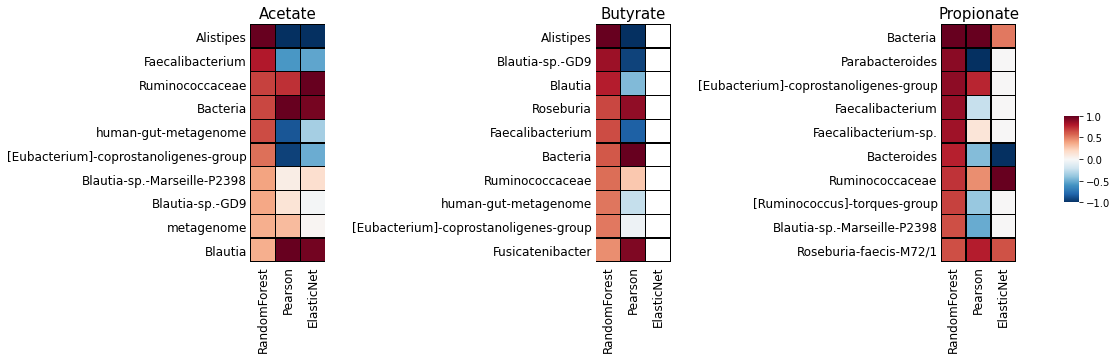

In [7]:
fig, ax = plt.subplots(figsize=(14, 6), nrows=1, ncols=3, constrained_layout=True, sharex=True)
cbar_ax = fig.add_axes([0.94, .45, .015, .2])
for k,scfa in enumerate(['Acetate','Butyrate','Propionate']):
    curr_df = df_joined[df_joined.SCFA==scfa].set_index('Taxon')
    curr_df = curr_df.drop('SCFA', axis=1)
    curr_df = curr_df.sort_values(by='RandomForest', ascending=False)
    curr_df = curr_df.iloc[0:10, :]
     
    # normalize to -1 and 1
    for c in ['ElasticNet','Pearson','RandomForest']:
        if c!='RandomForest':
            curr_df.loc[curr_df[c]<0,c] = curr_df.loc[curr_df[c]<0,c]/np.abs(curr_df.loc[curr_df[c]<0,c].min())
        curr_df.loc[curr_df[c]>=0,c] = curr_df.loc[curr_df[c]>=0,c]/curr_df.loc[curr_df[c]>=0,c].max()

    # plot    
    _ = sns.heatmap(curr_df.values, ax=ax[k], cmap='RdBu_r', vmin=-1, vmax=1, cbar = False if k!=2 else True, cbar_ax = None if k!=2 else cbar_ax, linewidths=0.25, linecolor='black')
    ax[k].set_xticklabels(['RandomForest','Pearson','ElasticNet'], rotation=90, fontsize=12)
    ax[k].set_title(scfa, fontsize=15)
    ax[k].set_yticklabels(curr_df.index, rotation=0, fontsize=12)
    ax[k].tick_params(axis=u'both', which=u'both',length=0)
plt.tight_layout()

In [33]:
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("scfa_producer_top10.pdf", format="pdf")